# Overview

The goal of this notebook is to explore the Google Play Store dataset in order to know more about the millions of apps that exist there. In order to learn about this data, we first start by cleaning and tidying it so we can be able to extract information from it.

Some of the things we are trying to learn about the data are:
- What is the average price of the apps?
- What are the app categories that dominate tha play store?
- Who are the apps mostly targeted for?
- What is the average rating of the apps?
- Is there a relationship between the category of the app and its reviews?

# Imports

In [162]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [43]:
# read in our data
store_data = pd.read_csv("data/google-play-store-apps/googleplaystore.csv")
reviews_data = pd.read_csv("data/google-play-store-apps/googleplaystore_user_reviews.csv")

In [44]:
# some stuff that could be used
# pd.isnull(store_data).sum() > 0
# store_data.isna().any(axis=0)
# store_data.loc[store_data['Price'].isnull()]
# print(store_data.iloc[5]['Price'])
# store_data[pd.isnull(store_data).any(axis=1)]

# Data Cleaning

## Checking out the missing values

First we inspect and check which attributes in the data have missing values.

In [45]:
pd.isnull(store_data).sum() > 0

App               False
Category          False
Rating             True
Reviews           False
Size              False
Installs          False
Type               True
Price             False
Content Rating     True
Genres            False
Last Updated      False
Current Ver        True
Android Ver        True
dtype: bool

The `Rating`, `Type`, `Content Rating`, `Current Ver`, `Android Ver` attributes turned out to have NaN values.

---

#### Type:

Let's start with `Type`; which is the attribute that indicates whether the app is `Paid` or `Free`.

In [46]:
store_data.loc[store_data['Type'].isnull()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9148,Command & Conquer: Rivals,FAMILY,NaN,0,Varies with device,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device


So the app in row `9148` named `Command & Conquer: Rivals` appears to be the only one with NaN value in `Type`.

Since its `Price` attribute holds a price of $0, we could safely assume that it is a free app and fix the value of the `Type` to `Free`. Also, this assumption is confirmed by checking that the app is indeed free on the Android play store.

In [47]:
store_data.iloc[9148, store_data.columns.get_loc('Type')] = 'Free'
store_data.loc[store_data['Type'].isnull()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


---

#### Rating:

The `Rating` attribute represent the rating given by the users for the app on a scale from 1 to 5.

In [48]:
store_data['Rating'].isnull().sum()

1474

There appears to be 1474 apps with missing rating values. There are a few approaches of adjusting these missing values. We decided to change each one of with a mean of ratings of other apps with same range of installs. For e.g: app 2 has a missing rating value and `100,000+` installs, if the mean rating of all the others apps with `100,000+` installs is `3.5`, then app 2's rating will be adjusted to `3.5`

We first start by grouping the data by the number of installs, and finding the mean rating for each range of number of installs. This forms "installs_rating_info" dataframe that will be further used for rating imputations. 0 installs were given 0 rating.

In [49]:
grouped_installs = store_data.groupby(["Installs"])
installs_rating_info = grouped_installs.agg(np.mean)
installs_rating_info = installs_rating_info.fillna(0)
installs_rating_info

,Rating
Installs,
0,0.000000
0+,0.000000
1+,5.000000
"1,000+",4.066760
"1,000,000+",4.220862
"1,000,000,000+",4.258621
10+,4.624638
"10,000+",4.039703
"10,000,000+",4.313419


A merge is formed between the "installs_rating_info" and another dataframe "nanRatings" that contains the same rows of "store_data" that contain the Rating "NaN" (1474 rows). This merge results in a new updated dataframe, called "updated_Rating" that has the same data as "nanRatings" but the "Rating" values have been replaced with the mean values per their number of installs values.

In [50]:
nanRatings = store_data[store_data['Rating'].isnull()]
nanRatings.rename(columns={'Rating':'Old_Rating'}, inplace=True)
updated_Rating = pd.merge(nanRatings, installs_rating_info, left_on='Installs', right_on='Installs').drop('Old_Rating', axis=1)

To impute the "store_data" rating values, we loop over the "updated_Rating" dataframe, replacing every rating of every row of NaN rating values in store_data with the respective rating of same application from updated_Rating df. This results in 0 NaN ratings in our data.

In [51]:
for index, row in updated_Rating.iterrows():
    indexOfApp = store_data[store_data['App']==row['App']].index
    store_data.at[indexOfApp, 'Rating'] = row['Rating']
    
print(store_data['Rating'].isnull().sum())

0


#### Shifted Row:
Row 10472 had shifted data by 1 to the left and a missing category value. To fix this, we shifted each cell by 1 and checked Google Playstore for its category and genre values, both are Lifestyle.

In [52]:
store_data.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                                 19
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [53]:
indexOfShiftedRow = store_data[store_data['App'] == store_data.iloc[10472]['App']].index[0]

In [54]:
store_data.at[indexOfShiftedRow,"Android Ver"] = store_data.at[indexOfShiftedRow,"Current Ver"]
store_data.at[indexOfShiftedRow,"Current Ver"] = store_data.at[indexOfShiftedRow,"Last Updated"]
store_data.at[indexOfShiftedRow,"Last Updated"] = store_data.at[indexOfShiftedRow,"Genres"]
store_data.at[indexOfShiftedRow,"Genres"] = "LifeStyle"
store_data.at[indexOfShiftedRow,"Content Rating"] = store_data.at[indexOfShiftedRow,"Price"]
store_data.at[indexOfShiftedRow,"Price"] = store_data.at[indexOfShiftedRow,"Type"]
store_data.at[indexOfShiftedRow,"Type"] = store_data.at[indexOfShiftedRow,"Installs"]
store_data.at[indexOfShiftedRow,"Installs"] = store_data.at[indexOfShiftedRow,"Size"]
store_data.at[indexOfShiftedRow,"Size"] = store_data.at[indexOfShiftedRow,"Reviews"]
store_data.at[indexOfShiftedRow,"Reviews"] = store_data.at[indexOfShiftedRow,"Rating"]
store_data.at[indexOfShiftedRow,"Rating"] = store_data.at[indexOfShiftedRow,"Category"]
store_data.at[indexOfShiftedRow,"Category"] = "LIFESTYLE"

In [55]:
store_data.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                        LIFESTYLE
Rating                                                1.9
Reviews                                                19
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                          LifeStyle
Last Updated                            February 11, 2018
Current Ver                                        1.0.19
Android Ver                                    4.0 and up
Name: 10472, dtype: object

#### Andriod Version:

Two rows have missing 'Andriod Ver' attribute, their andriod version values will be retrieved from the Google Playstore and filled by this values.

In [56]:
store_data['Android Ver'].isnull().sum()

2

In [57]:
store_data[store_data['Android Ver'].isnull() == True ]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4453,[substratum] Vacuum: P,PERSONALIZATION,4.4,230,11M,"1,000+",Paid,$1.49,Everyone,Personalization,"July 20, 2018",4.4,NaN
4490,Pi Dark [substratum],PERSONALIZATION,4.5,189,2.1M,"10,000+",Free,0,Everyone,Personalization,"March 27, 2018",1.1,NaN


In [58]:
store_data.at[4490, "Android Ver"] = 1.1
store_data.at[4453, "Android Ver"] = 6.1

In [59]:
store_data[store_data['Android Ver'].isnull() == True ]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


In [60]:
pd.isnull(store_data).sum() > 0

App               False
Category          False
Rating            False
Reviews           False
Size              False
Installs          False
Type              False
Price             False
Content Rating    False
Genres            False
Last Updated      False
Current Ver        True
Android Ver       False
dtype: bool

Now this dataset is cleaned with no missing values in any attribute except 'Current Ver' because its imputation won't be of major consequences to our data handling.

#### Google Playstore UserReviews:

We need to clean this data as well, this would be easier, any null values of reviews will be dropped because it can't be imputed.

In [61]:
pd.isnull(reviews_data).sum() 

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [62]:
reviews_data_new = reviews_data.dropna().head()
reviews_data_new

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [63]:
pd.isnull(reviews_data_new).sum() 

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

## Data Tidying

Now that we handled all our missing values, we will put our dataset in a form that will help us to visualize the data and extract the useful information from it.

In [64]:
store_data.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

First, we'll change `Reviews` column to be `int`.

In [65]:
store_data.Reviews = store_data.Reviews.astype('int32')

Then, we'll change `Price` column to be `float`.

In [66]:
for index, row in store_data.iterrows():
    store_data.at[index, 'Price'] = row['Price'].replace('$', '')
store_data.Price = store_data.Price.astype('float64')
store_data.dtypes

App                object
Category           object
Rating            float64
Reviews             int32
Size               object
Installs           object
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

Next is changing the `Installs` to be `int`.

In [67]:
store_data['Installs'] = store_data['Installs'].str.replace('+','')
store_data['Installs'] = store_data['Installs'].str.replace(',','')
store_data['Installs'] = store_data['Installs'].astype('int32')

Finally, we're changing the `Size` to be `float`.

In [68]:
store_data_copy = store_data.copy()
store_data_copy['Size'] = store_data_copy['Size'].str.replace('k','e+3')
store_data_copy['Size'] = store_data_copy['Size'].str.replace('M','e+6')
store_data_copy['Size'] = store_data_copy['Size'].replace('Varies with device', np.nan)
store_data_copy['Size'] = store_data_copy['Size'].astype('float')

And for the column `Genres`, we have values separated by a `;`. So we'll fix that so we can have one value per cell

In [212]:
for index, row in store_data.iterrows():
    genreCell = row["Genres"].split(';')
    if(len(genreCell) > 1):
        store_data.at[index, 'Subgenre'] = genreCell[1]

In [213]:
store_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Subgenre
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,NaN
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,Pretend Play
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,NaN
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,NaN
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,Creativity


Now done with the data cleaning for both datasets, time for our next step!

# Data Visualization

Now it's time to answer our questions! We use different data visualizing methods in order to do so and we provide the answers we get along the way.

First, let's explore the `Category` attribute. We start by seeing if there are certain categories that exist more than others in the app store.

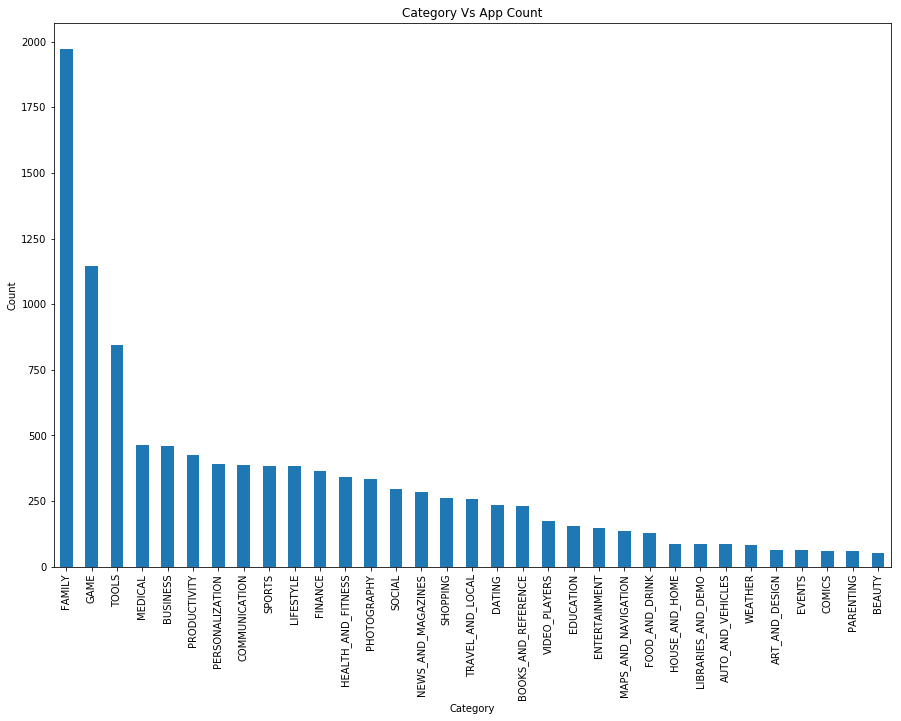

In [69]:
plt.figure(figsize=(15,10))
store_data.Category.value_counts().plot(kind="bar");
plt.title("Category Vs App Count")
plt.xlabel("Category")
plt.ylabel("Count")
plt.plot();

We can clearly see that the categoreis `Family` and `Game` dominate the app store more the other categories

Next, let's see if there is a relationship between the categories and the rating in order to see if there are certain categories that get higher ratings than others.

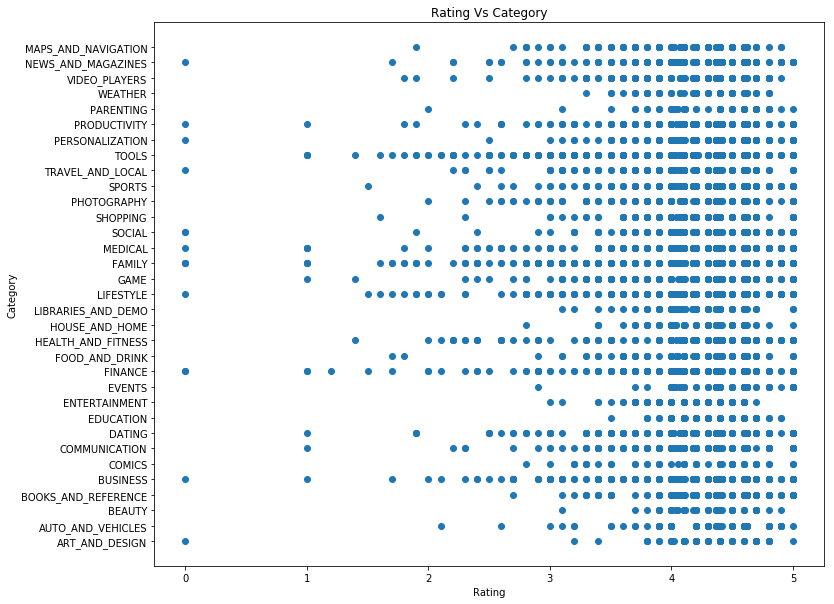

In [70]:
fig = plt.figure(figsize=(12,10))
plt.title("Rating Vs Category")
plt.xlabel("Rating")
plt.ylabel("Category")
plt.show(plt.scatter(store_data.Rating, store_data.Category))

We can see from the figure that there are no categories that do significantly better than others in terms of ratings.

Next, let's explore the `Price`s of the apps. We start by seeing the counts of the Paid and Free apps.

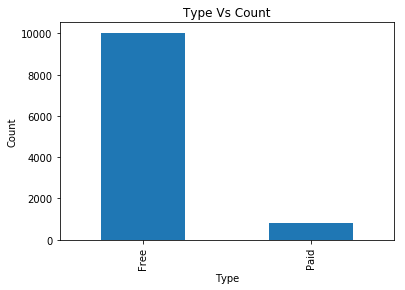

In [71]:
plt.title("Type Vs Count")
plt.xlabel("Type")
plt.ylabel("Count")
store_data_copy['Type'].value_counts().plot(kind='bar')

As we can see the free apps dominate the app store more than the paid ones

Next, we wanted to see the distribution of prices of the paid apps.

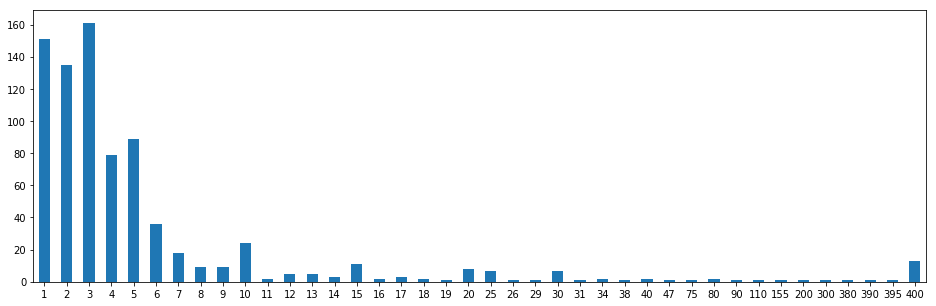

In [174]:
df = store_data[store_data.Price != 0.0]
df = df.sort_values(by='Price', ascending=True)
df['PriceRange'] = 0
for index, row in df.iterrows():
    df.at[index, 'PriceRange'] = math.ceil(row['Price'])

indexes = list(df['PriceRange'].values)
indexes = list(dict.fromkeys(indexes))
# indexes

df['PriceRange'].value_counts().loc[indexes].plot(kind='bar', rot=0, figsize=(16, 5))

As we can see most of the paid apps range between 1-5 

Next, we will explore the `Content Rating` attribute. Let's see which age group is targeted more in the app store.

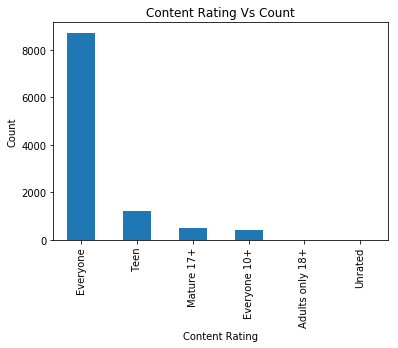

In [73]:
store_data["Content Rating"].value_counts().plot(kind="bar");
plt.title("Content Rating Vs Count");
plt.xlabel("Content Rating");
plt.ylabel("Count");
plt.plot();

As we can see there is no certain age group that is more targeted by the app store and the apps are mostly for everyone.

Next, let's see the `Rating` attribute. We wanted to know the average ratings of the apps.

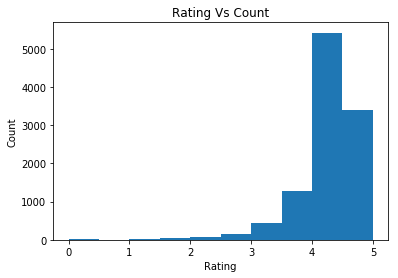

In [74]:
store_data.Rating.plot(kind="hist")
plt.title("Rating Vs Count");
plt.xlabel("Rating");
plt.ylabel("Count");

As we can see most app ratings are between 4 and 5.

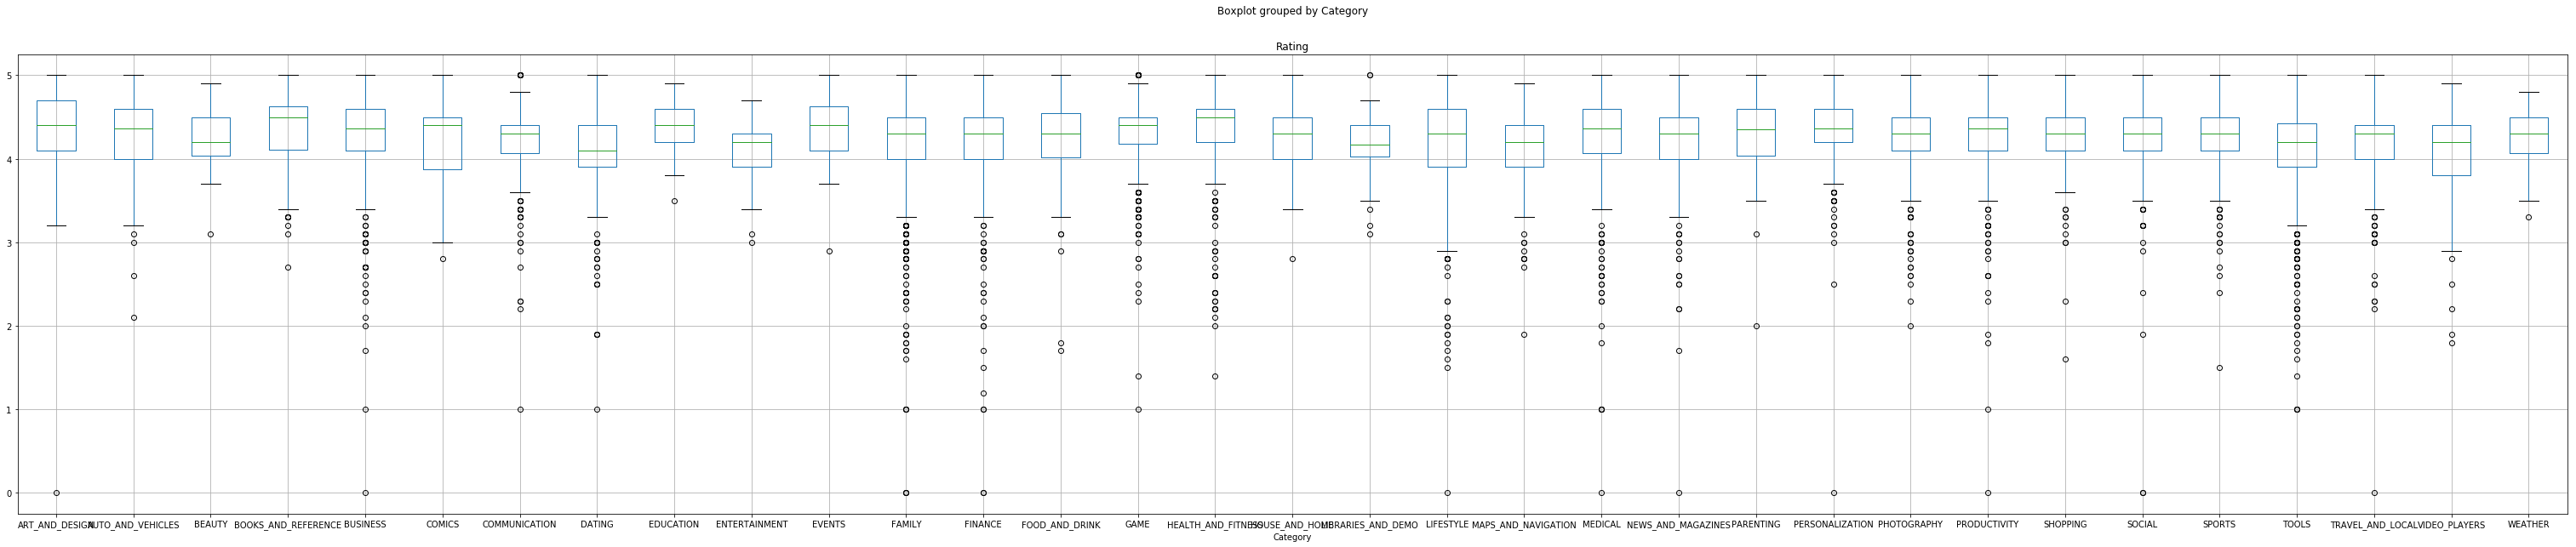

In [75]:
store_data_copy.boxplot(column='Rating', by='Category', figsize=(52,10))

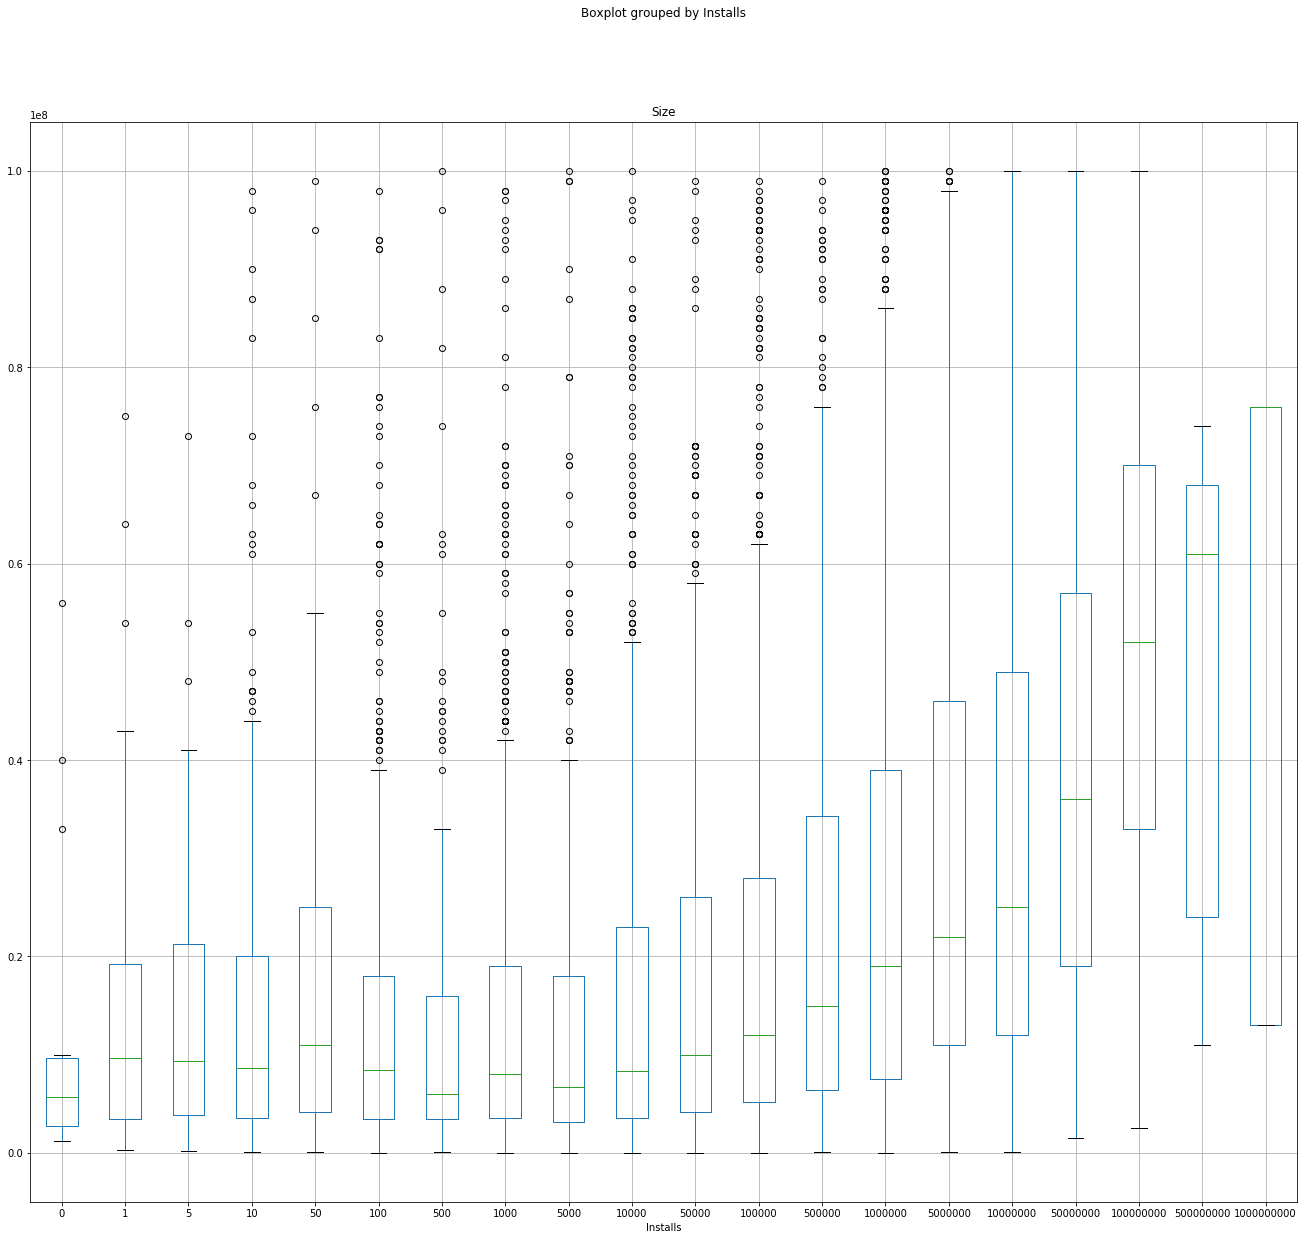

In [76]:
store_data_copy.boxplot(column='Size', by='Installs', figsize=(22,20))

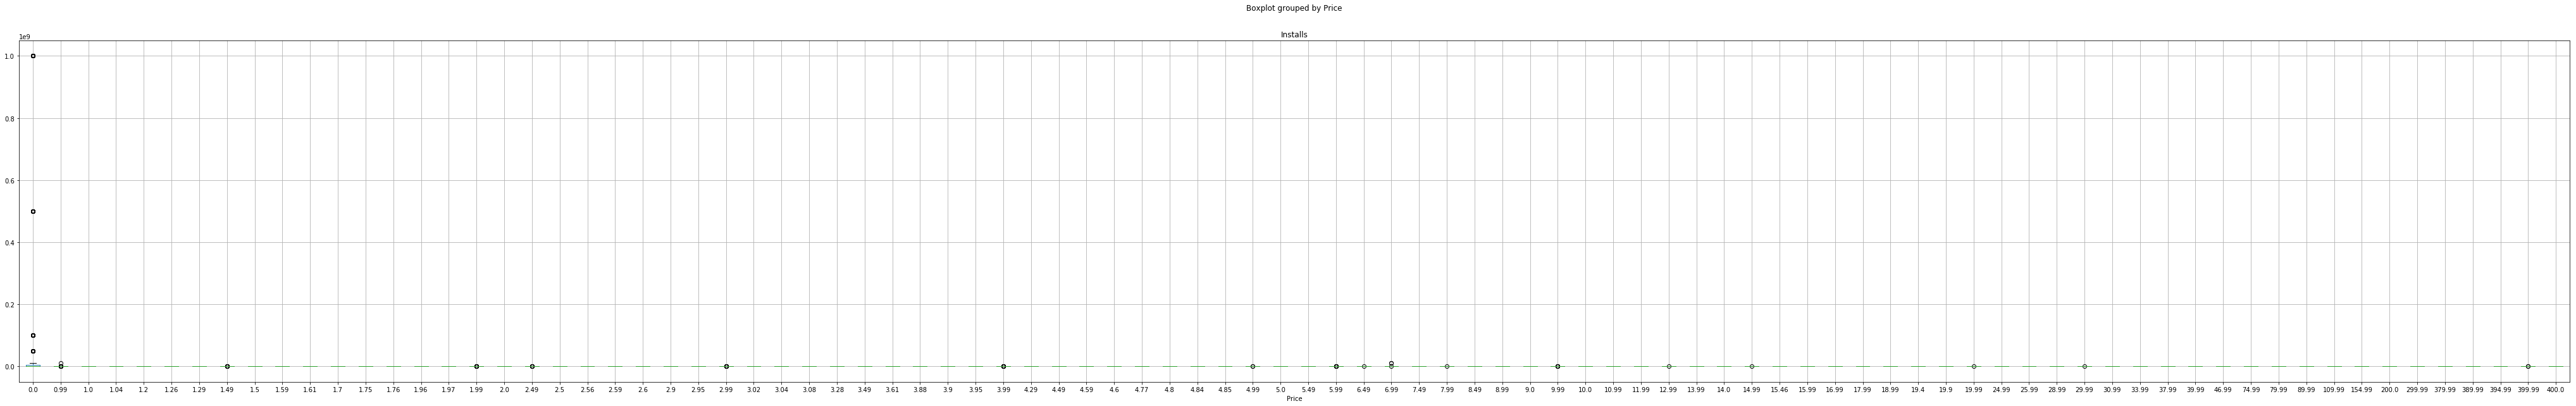

In [77]:
store_data_copy.boxplot(column='Installs', by='Price', figsize=(70,10))

Done: (Price & Count), (Type & Count), (Category & Rating) 


Yet to be done: 1- Visualization: Installs & Price, Installs & Category (Installs axis can be entered as an array of the unique Installs values)


   2- Cleaning: Split Genres


Attempted: Size & Installs

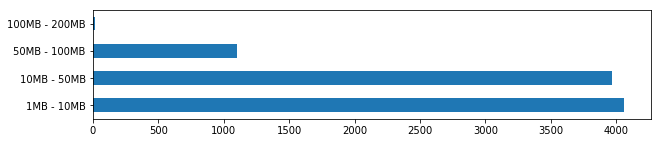

In [153]:
SizeRangeOrdered = ['1MB - 10MB', '10MB - 50MB' , '50MB - 100MB', '100MB - 200MB']

store_data_copy['SizeRange'] = 'NaN'
store_data_copy['SizeRange'].values[1 * 1e9 <= store_data_copy['Size']] = '1GB+'
store_data_copy['SizeRange'].values[store_data_copy['Size'] < 1 * 1e9] = '500MB - 1GB'
store_data_copy['SizeRange'].values[store_data_copy['Size'] < 500 * 1e6] = '200MB - 500MB'
store_data_copy['SizeRange'].values[store_data_copy['Size'] < 200 * 1e6] = '100MB - 200MB'
store_data_copy['SizeRange'].values[store_data_copy['Size'] < 100 * 1e6] = '50MB - 100MB'
store_data_copy['SizeRange'].values[store_data_copy['Size'] < 50 * 1e6] = '10MB - 50MB'
store_data_copy['SizeRange'].values[store_data_copy['Size'] <= 10 * 1e6] = '1MB - 10MB'
store_data_copy['SizeRange'].values[store_data_copy['SizeRange'] == 'NaN'] = np.nan

store_data_copy['SizeRange'].dropna().value_counts().plot(kind='barh', figsize=(10,2))

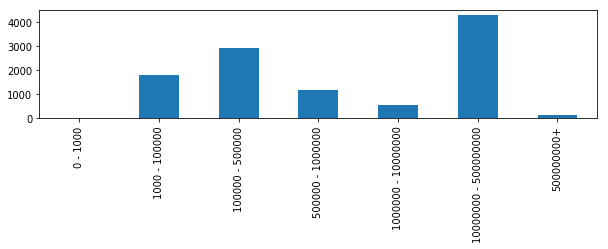

In [151]:
installs_ranges_array = ['0 - 1000', '1000 - 100000', '100000 - 500000', '500000 - 1000000', '1000000 - 10000000', '10000000 - 500000000', '500000000+']
store_data_copy['InstallsRange'] = 'NaN'
store_data_copy['InstallsRange'].values[5 * 1e8 <= store_data_copy['Installs']] = '500000000+'
store_data_copy['InstallsRange'].values[store_data_copy['Installs'] < 5 * 1e8] = '10000000 - 500000000'
store_data_copy['InstallsRange'].values[store_data_copy['Installs'] < 1 * 1e6] = '1000000 - 10000000'
store_data_copy['InstallsRange'].values[store_data_copy['Installs'] < 5 * 1e5] = '500000 - 1000000'
store_data_copy['InstallsRange'].values[store_data_copy['Installs'] < 1 * 1e5] = '100000 - 500000'
store_data_copy['InstallsRange'].values[store_data_copy['Installs'] < 1 * 1e3] = '1000 - 100000'
store_data_copy['InstallsRange'].values[store_data_copy['Installs'] <= 0] = '0 - 1000'
store_data_copy['InstallsRange'].values[store_data_copy['InstallsRange'] == 'NaN'] = np.nan

store_data_copy['InstallsRange'].dropna().value_counts().loc[installs_ranges_array].plot(kind='bar', figsize=(10,2))

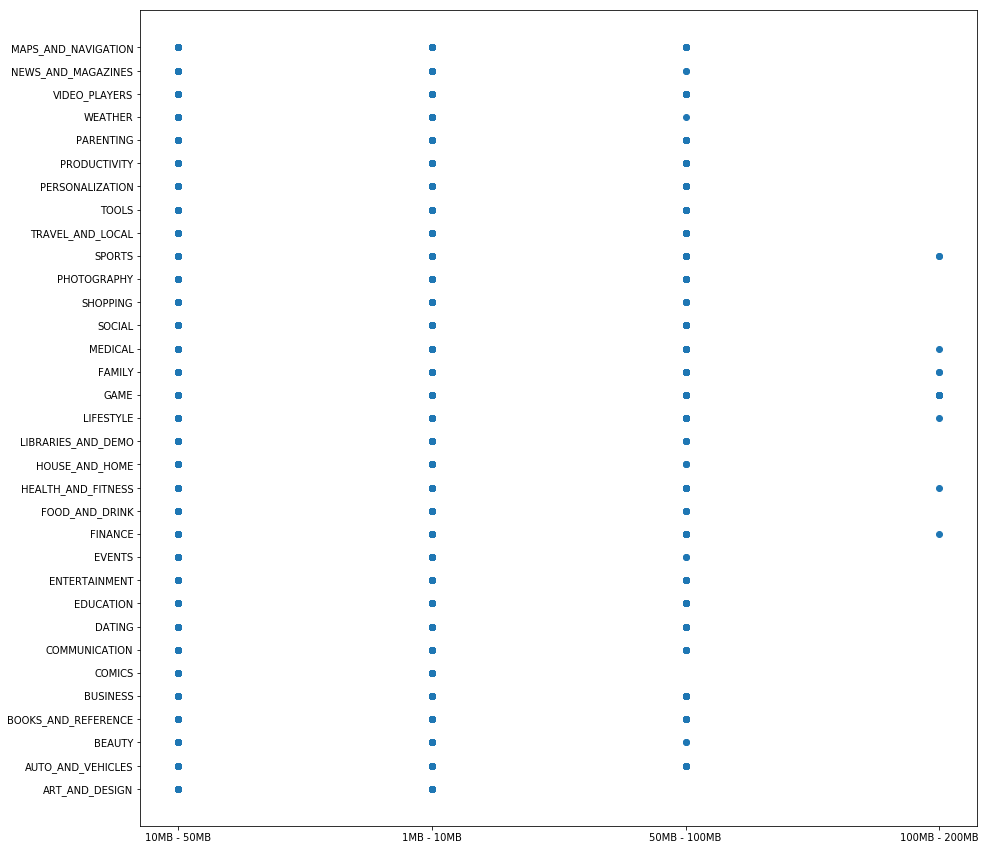

In [176]:
plt.figure(figsize=(15, 15))
plt.show(plt.scatter(store_data_copy.dropna().SizeRange, store_data_copy.dropna().Category))

We want to see the relationship between the `Size` and the `Installs` for all the applications per category. The following graphs show the comparison between the count of applications per category for each size range and each graph has a fixed install range.

This graph below plots the number of applications count for each category, with each color representing a size range, for 100,000-500,000 number of installs.

In [109]:
installs_ranges_array = ['0 - 1000', '1000 - 100000', '100000 - 500000', '500000 - 1000000', '1000000 - 10000000', '10000000 - 500000000', '500000000+']

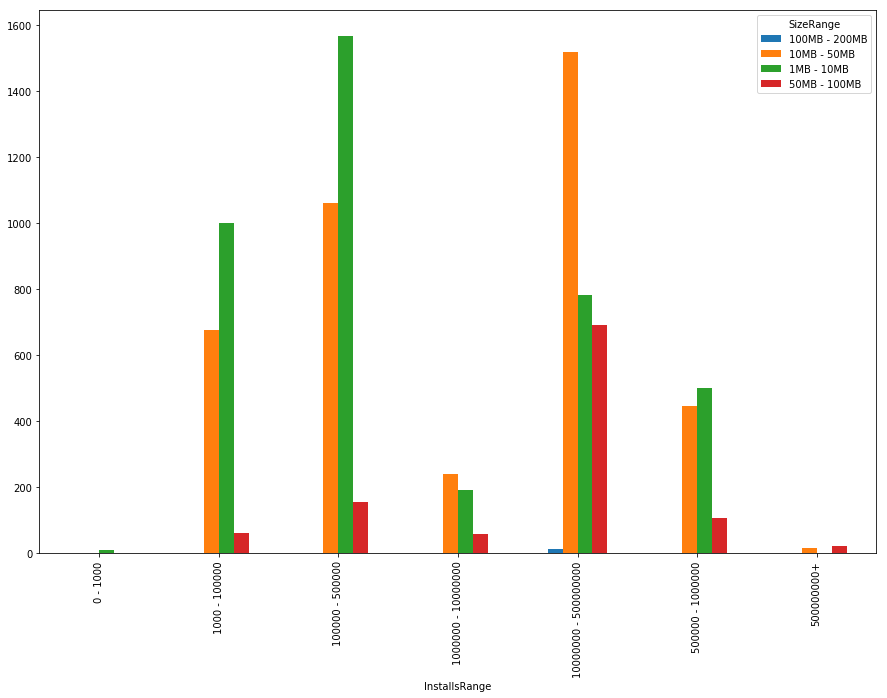

In [130]:
SizeRangeOrdered = ['1MB - 10MB', '10MB - 50MB' , '50MB - 100MB', '100MB - 200MB']
pd.crosstab(store_data_copy.dropna().InstallsRange, store_data_copy.dropna().SizeRange.sort_values(ascending=True)).plot(kind="bar",figsize=(15, 10));
#current_handles, current_labels = plt.gca().get_legend_handles_labels()
#plt.legend(current_handles,SizeRangeOrdered)


In [225]:
installs_ranges_array
SizeRangeOrdered
store_data_copy['InstallsRange'] = store_data_copy['InstallsRange'].astype('category')
store_data_copy['SizeRange'] = store_data_copy['SizeRange'].astype('category')
store_data_copy.dtypes
plt.figure(figsize=(13, 10))
#plt.scatter(store_data_copy.dropna().InstallsRange, store_data_copy.dropna().SizeRange)
ax = sns.stripplot(x="InstallsRange", y="SizeRange", data=store_data_copy)

ValueError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 936x720 with 0 Axes>

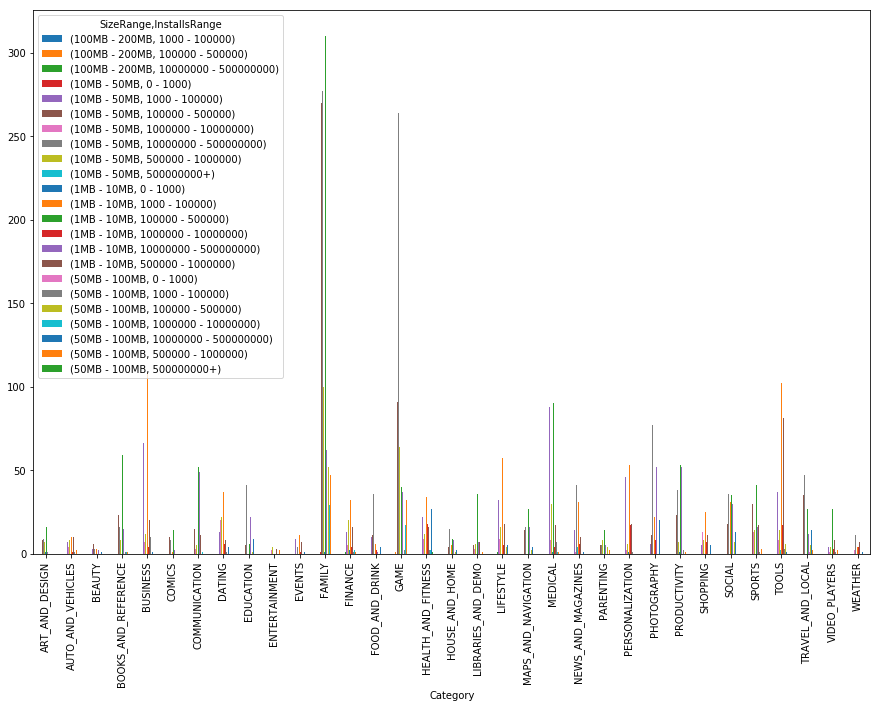

In [220]:
SizeRangeOrdered = ['1MB - 10MB', '10MB - 50MB' , '50MB - 100MB', '100MB - 200MB']
df_plot = pd.crosstab(store_data_copy.dropna().Category, [store_data_copy.dropna().SizeRange, store_data_copy['InstallsRange']])
# df_plot.plot(kind="bar",figsize=(15, 10))

#current_handles, current_labels = plt.gca().get_legend_handles_labels()
#plt.title("Graph for 100,000-500,000 number of installs.")
#plt.xlabel("Category")
#plt.ylabel("Count of Applications")
#plt.legend(current_handles,SizeRangeOrdered)
#print(store_data_copy.dropna().InstallsRange)

fig, ax = plt.subplots()
df_plot.plot(kind="bar",figsize=(15, 10), ax=ax)
# ax.legend(SizeRangeOrdered);


In [ ]:
SizeRangeOrdered = ['1MB - 10MB', '10MB - 50MB' , '50MB - 100MB', '100MB - 200MB']
pd.crosstab(store_data_copy.dropna().Category, [store_data_copy.dropna().SizeRange.sort_values(ascending=True), store_data_copy.dropna().InstallsRange[1]]).plot(kind="bar",figsize=(15, 10));
current_handles, current_labels = plt.gca().get_legend_handles_labels()
plt.title("Graph for 500,000-500,000 number of installs.")
plt.xlabel("Category")
plt.ylabel("Count of Applications")
plt.legend(current_handles,SizeRangeOrdered)



In [ ]:
store_data_copy.hist(column='Size', bins=110, grid=False, figsize=(10, 5), zorder=2, alpha=0.7)

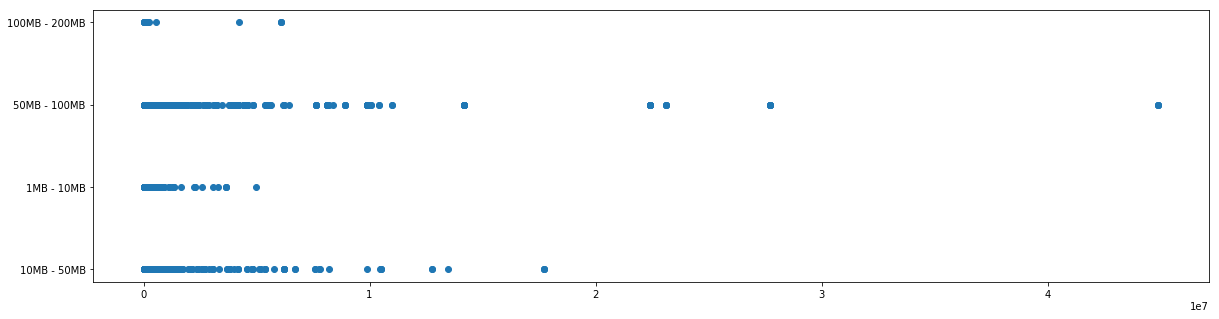

In [204]:
plt.figure(figsize=(20, 5))
plt.show(plt.scatter(store_data_copy.dropna().Reviews, store_data_copy.dropna().SizeRange))

In [ ]:
store_data_copy.boxplot(column='Installs', by='SizeRange', figsize=(10,5))

In [ ]:
store_data_copy.boxplot(column='Rating', by='SizeRange', figsize=(10,5))

In [ ]:
store_data_copy.boxplot(column='Reviews', by='SizeRange', figsize=(10,5))

In [ ]:
store_data_copy.boxplot(column='Reviews', by='Category', figsize=(70,8))

---